# Generative InfraCGI using ClipSeg and Stable Diffusion Inpainting

Infrastructure CGI, but there's a potentially infinite amount of it. Cobbled together from demo notebooks for running in Colab

* ClipSeg for masking out parts of an image from text prompts
* Stable Diffusion for inpainting the mask from a text prompt.

Run in colab! Install dependencies, use a Huggingface access token to download the models, then insert your image URL and experiment with the prompts!

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

To use private and gated models on 🤗 Hugging Face Hub, login is required.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [4]:
device = "cuda"
model_path = "stabilityai/stable-diffusion-2-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Image link of a street scene. Any image will do

In [142]:
image_url = "https://www.dropbox.com/s/4wuuyuya62hz73g/20230520_103907.jpg?dl=1"
#image_url = "https://www.dropbox.com/s/8tf4hvsigtmnbzm/20230516_193229.jpg?dl=1"

In [17]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    """Draw a grid for viewing output"""
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def download_image(url):
    """Grab an image, crop it to a square and resize to 512x512 pixels"""
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content)).convert("RGB")
    crop_max = min(img.height, img.width)
    img = crop_center(img, crop_max, crop_max)
    return img.resize([512, 512])


def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

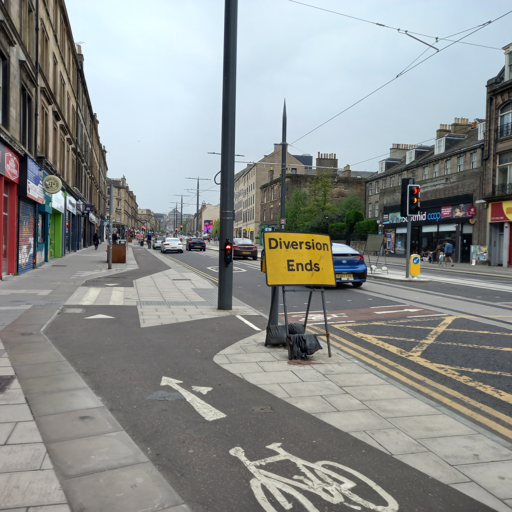

In [143]:
image = download_image(image_url)
image

Use ClipSeg to extract the road environment from the image, leaving the rest.

List of prompts describing the objects to pick out, may need tweaking, e.g. if your image has a lot of signage in it


In [144]:
prompts = ["road", "pavement", "car", "post", "streetlamp", "fence"]

In [145]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)


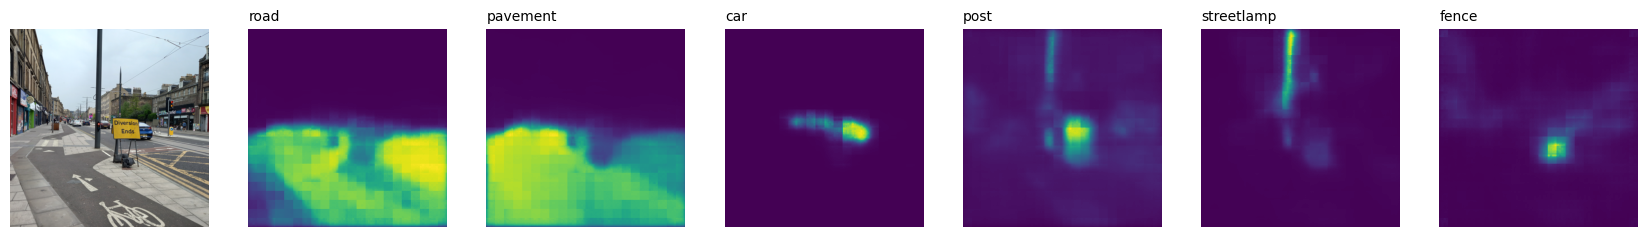

In [146]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

Combine all the masks into one binary mask but in RGB form (which the inpainting pipline likes)

In [147]:
threshold = 0.1

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

In [148]:
mask = np.uint8(inds.numpy().astype(int))
mask[mask!=0] = 255
masked_image = PIL.Image.fromarray(mask).convert('RGB').resize([512, 512])

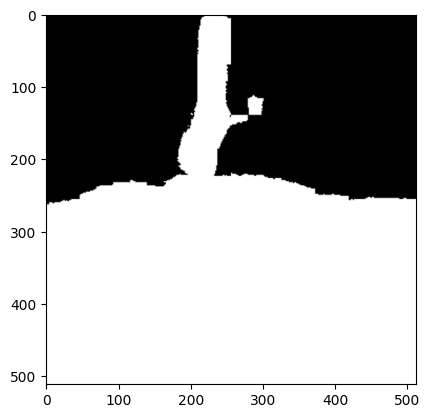

In [149]:
plt.imshow(masked_image)

In [150]:
prompt = "bike path, natural textures, Scottish landscape, cloudy day"

# Adjust this option to vary more
guidance_scale=16

# change the seed to get different results
seed = 0

# Render this many alternate versions
num_samples = 3

generator = torch.Generator(device="cuda").manual_seed(seed)

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=masked_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

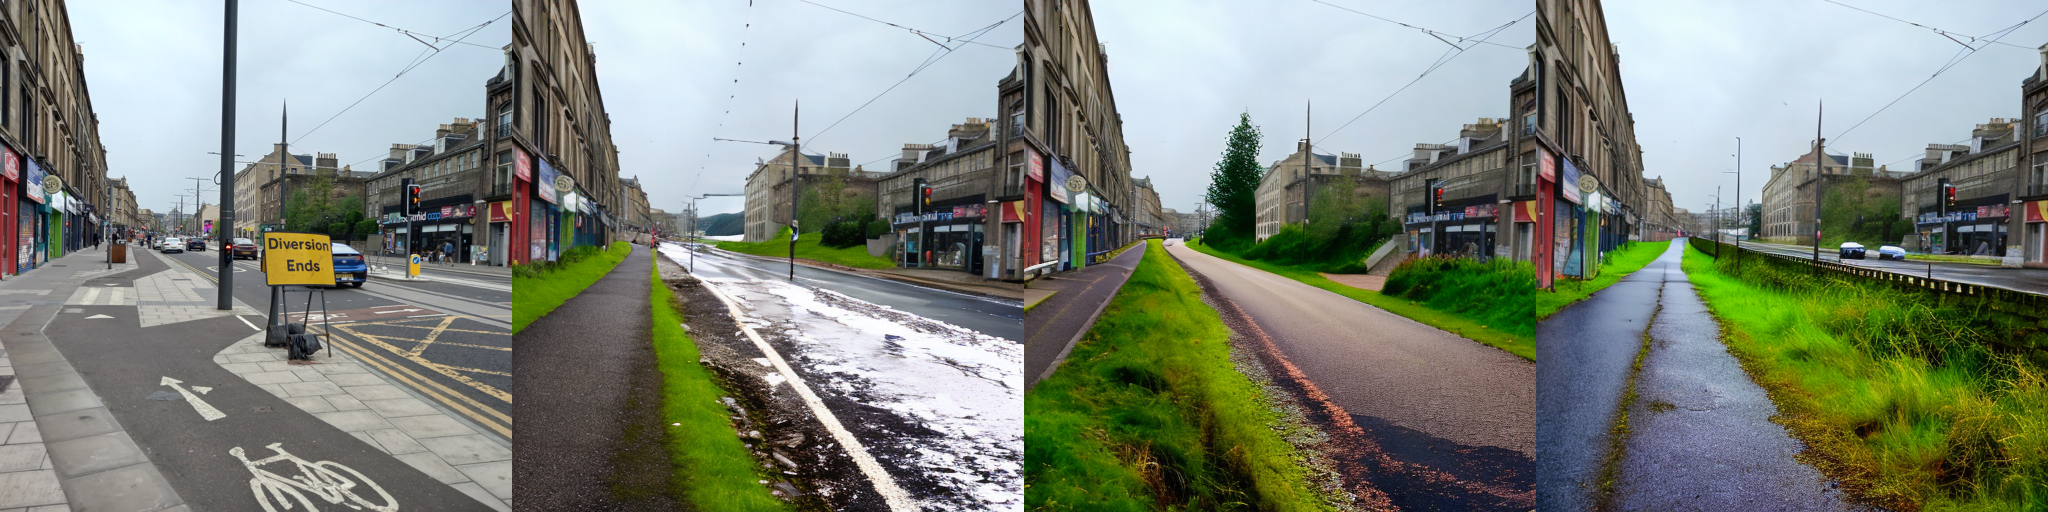

In [151]:
# insert initial image in the list so we can compare side by side
images.insert(0, image)
image_grid(images, 1, num_samples + 1)